# qiskit angle images

## Load and preprocess our data

In [1]:
# get pandas running
#import numpy as np
import pandas as pd
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance

#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

In [2]:
#read in image
import cv2
import os 
print(os.path.exists(r'.\images\vecteezy_snowman-icon-black-and-white_.png'))


# read the image file
img = cv2.imread(r"./images/vecteezy_snowman-icon-black-and-white_.png", cv2.IMREAD_COLOR)
#print(type(img))

# converting to its binary form
ret, img_thres = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

print(type(img_thres))
#print(img_thres)
print(img_thres.shape)

print(img_thres[0][0])
arr=np.ones((200,200))
for y in range(200):
    for x in range(200):
        if img_thres[y][x][0] == 255 and img_thres[y][x][1] == 255 and img_thres[y][x][2] == 255:
            arr[y][x]=-1.0

#print(arr)


True
<class 'numpy.ndarray'>
(200, 200, 3)
[255 255 255]


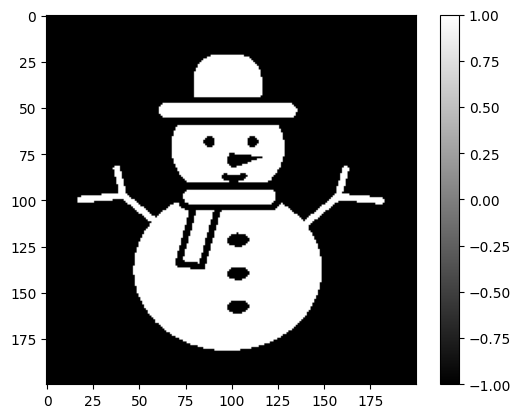

In [3]:
import matplotlib.pyplot as plt

plt.imshow(arr, cmap='gray',vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.show()

In [4]:
#now create our training and test sets
num_samples = 4000
np.random.seed(42)

rand_base = 100000

# input X (0..1, 0..1) y = -1.0,1.0
X = np.random.rand(num_samples,2)
y = np.zeros(num_samples)

for sample in range(num_samples):
    y[sample]=arr[int(X[sample][0]*200)][int(X[sample][1]*200)]
                                                      

In [5]:
from sklearn.model_selection import train_test_split

# split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#y_train = y_train * 2 - np.ones(len(y_train))  # shift label from {0, 1} to {-1, 1}
#y_test = y_test * 2 - np.ones(len(y_test))  # shift label from {0, 1} to {-1, 1}

print(X_train)
print(y_train)

[[0.35883048 0.87720054]
 [0.03778451 0.64336973]
 [0.7199968  0.10116562]
 ...
 [0.14224937 0.12138494]
 [0.50426346 0.86564504]
 [0.59625858 0.70973708]]
[-1. -1. -1. ... -1.  1.  1.]


In [6]:
for i in range(10):
    print("X = {}, Y = {: d}".format(X_train[i], int(y_train[i])))

print("...")

X = [0.35883048 0.87720054], Y = -1
X = [0.03778451 0.64336973], Y = -1
X = [0.7199968  0.10116562], Y = -1
X = [0.70327723 0.83445825], Y = -1
X = [0.46380982 0.1739774 ], Y = -1
X = [0.96292688 0.48354565], Y = -1
X = [0.80348274 0.92922805], Y = -1
X = [0.48501799 0.08540303], Y = -1
X = [0.51832392 0.46180648], Y = -1
X = [0.25566622 0.36456643], Y =  1
...


## Now put up our qnn

In [15]:
#now some further imports
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN

In [16]:
def parity(x):
    return "{:b}".format(x).count("1") % 2

In [17]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [18]:
num_inputs = 2
feature_map = ZZFeatureMap(num_inputs)
    
ansatz = RealAmplitudes(num_inputs, entanglement='reverse_linear', reps=3)
print(ansatz)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))


     ┌──────────────────────────────────────────────────────────┐
q_0: ┤0                                                         ├
     │  RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) │
q_1: ┤1                                                         ├
     └──────────────────────────────────────────────────────────┘


In [22]:
output_shape = 2

circuit_qnn = CircuitQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, interpret=parity, output_shape=output_shape, quantum_instance=quantum_instance)

In [29]:
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [30]:
# turn labels from 1d to 2d
y_train_2d = np.zeros((len(y_train),2))
y_test_2d = np.zeros((len(y_test),2))

for i in range(len(y_train)):
    if y_train[i] == -1.0:
        y_train_2d[i][0] = -1.0
        y_train_2d[i][1] = 1.0
    else:
        y_train_2d[i][0] = 1.0
        y_train_2d[i][1] = -1.0
        
for i in range(len(y_test)):
    if y_test[i] == -1.0:
        y_test_2d[i][0] = -1.0
        y_test_2d[i][1] = 1.0
    else:
        y_test_2d[i][0] = 1.0
        y_test_2d[i][1] = -1.0        

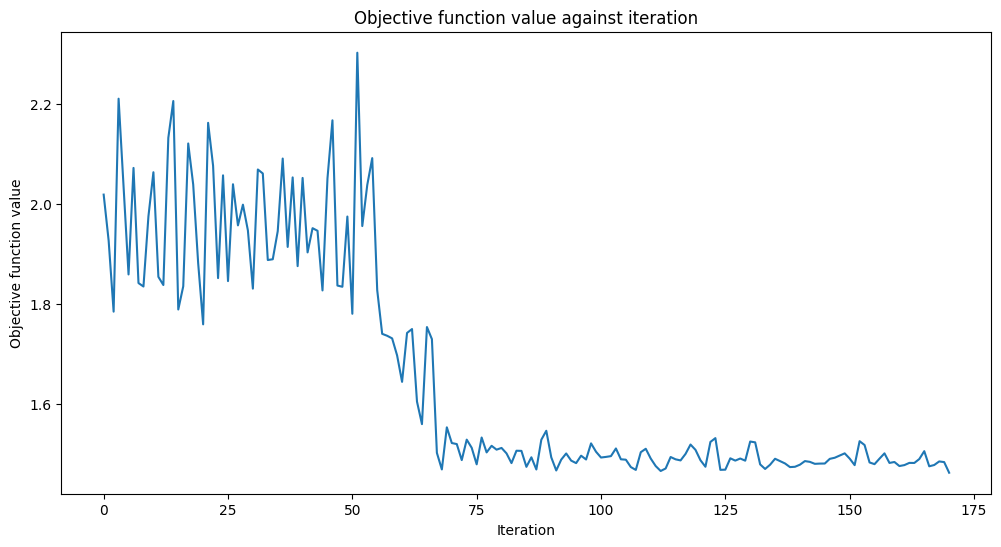

0.0


In [31]:
#now train our network
from qiskit.algorithms.optimizers import SPSA

# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

circuit_classifier = NeuralNetworkClassifier(
        circuit_qnn, optimizer=SPSA(maxiter=60), callback=callback_graph
    )

circuit_classifier.fit(X_train, y_train_2d[:,0])
y_predict = circuit_classifier.predict(X_test)
score_val = circuit_classifier.score(X_test, y_test_2d[:,0])

print(score_val)

Score of 0.92. This seems to be quite good!

In [32]:
print(score_val)

0.0


In [33]:
predictions = y_predict

## Now some results

In [34]:
for i in range(10):
    print("X = {}, Y-test = {: d}, Y-predicted = {: d}".format(X_test[i], int(y_test[i]), int(predictions[i])))

print("...")

X = [0.81583312 0.22444057], Y-test = -1, Y-predicted =  0
X = [0.93482204 0.83495678], Y-test = -1, Y-predicted =  0
X = [0.99793411 0.35071182], Y-test = -1, Y-predicted =  0
X = [0.30321955 0.69799047], Y-test = -1, Y-predicted =  0
X = [0.53758114 0.57579247], Y-test =  1, Y-predicted =  0
X = [0.96244729 0.2517823 ], Y-test = -1, Y-predicted =  0
X = [0.97534313 0.81697391], Y-test = -1, Y-predicted =  0
X = [0.0912061 0.4944203], Y-test = -1, Y-predicted =  0
X = [0.37201809 0.77641296], Y-test = -1, Y-predicted =  0
X = [0.06761256 0.80035651], Y-test = -1, Y-predicted =  1
...


## Recreate picture from predictions

In [36]:
X_aquidistant = np.zeros((200*200,2))

for y in range(200):
    for x in range(200):
        X_aquidistant[y*200+x][0] = y/200
        X_aquidistant[y*200+x][1] = x/200

print(X_aquidistant)

[[0.    0.   ]
 [0.    0.005]
 [0.    0.01 ]
 ...
 [0.995 0.985]
 [0.995 0.99 ]
 [0.995 0.995]]


In [37]:
y_aquidistant = circuit_classifier.predict(X_aquidistant)

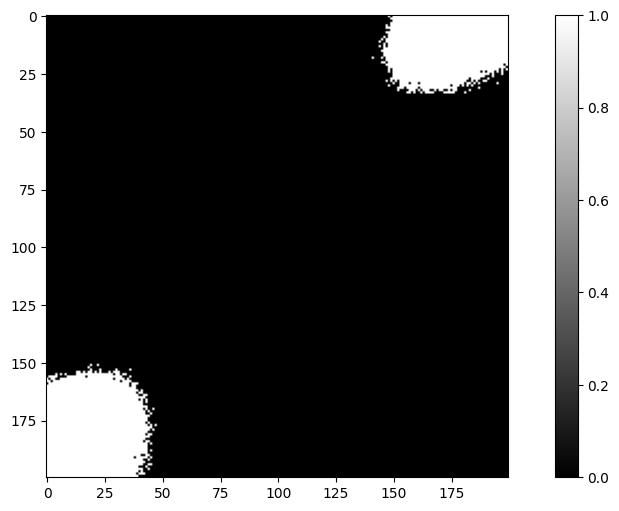

In [38]:
arr2=np.zeros((200,200))

for y in range(200):
    for x in range(200):
        if (y_aquidistant[y*200+x] == 1.0):
            arr2[y][x] = 1.0

import matplotlib.pyplot as plt

plt.imshow(arr2, cmap='gray',vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

Not bad for first shot with 4000 samples

### OpflowQNN with same dataset

In [44]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

In [45]:
# X_train, X_test, y_train_2d, y_test_2d, X_aquidistant, y_aquidistant
y_train_2d

num_inputs=2
opflow_qnn = TwoLayerQNN(num_inputs, quantum_instance=quantum_instance)

opflow_qnn.forward(X_train[0, :], algorithm_globals.random.random(opflow_qnn.num_weights))

array([[0.69335938]])

In [46]:
# here we create an empty array for callback to store evaluations of the objective function when we train our model
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [47]:
opflow_classifier = NeuralNetworkClassifier(
        opflow_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
    )

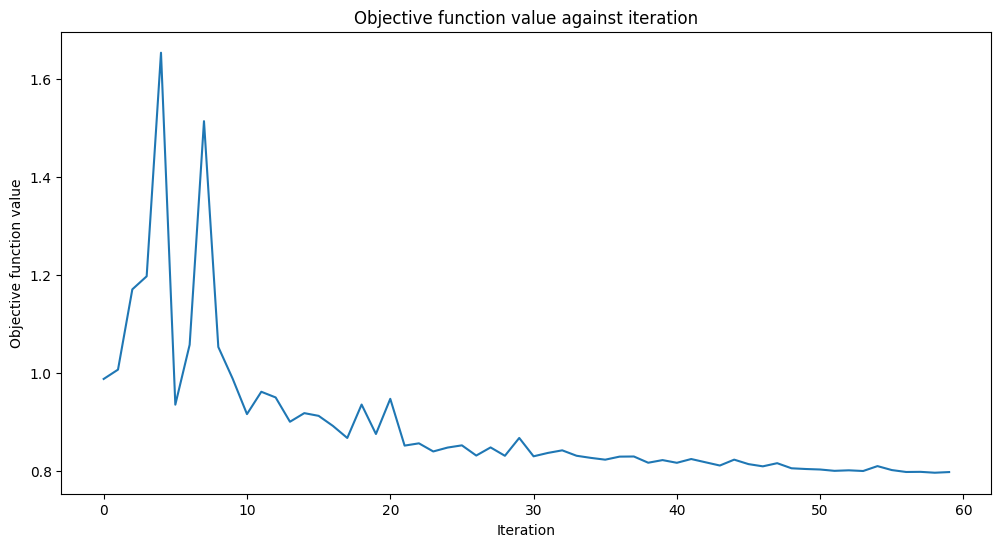

In [48]:
opflow_classifier.fit(X_train, y_train_2d[:,0])
y_predict = opflow_classifier.predict(X_test)
score_val = opflow_classifier.score(X_test, y_test_2d[:,0])

In [49]:
predictions = y_predict

In [50]:
y_aquidistant = opflow_classifier.predict(X_aquidistant)

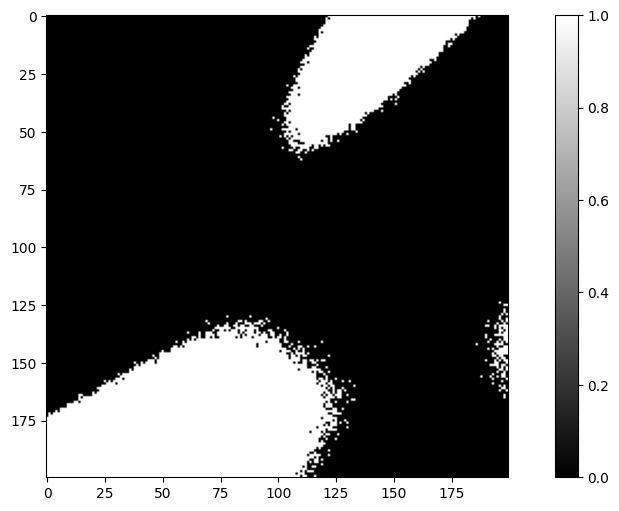

In [51]:
arr2=np.zeros((200,200))

for y in range(200):
    for x in range(200):
        if (y_aquidistant[y*200+x] == 1.0):
            arr2[y][x] = 1.0

import matplotlib.pyplot as plt

plt.imshow(arr2, cmap='gray',vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

In [52]:
print(score_val)

0.6674242424242425
